# Creating a custom KNN algorithm to predict age of abalone snails

Inspired by <a href='https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/'>this</a> tutorial on creating custom KNN algorithm

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load data
df = pd.read_csv('abalone.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
#name the columns
df.columns = ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight',
             'VisceraWeight', 'ShellWeight', 'Rings']
df.head(10)

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


Here's what the attributes mean (<a href='https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names'>source</a>):

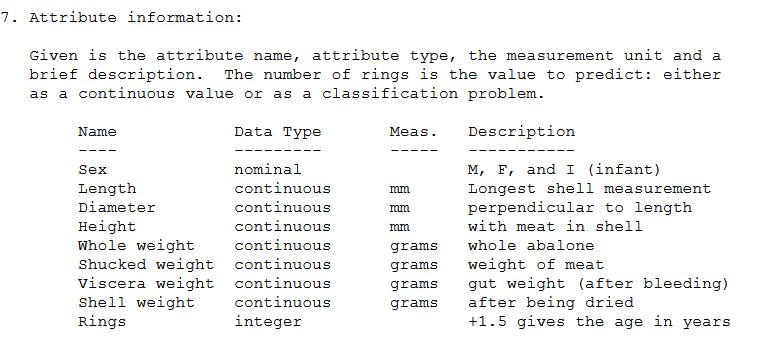

Although the dataset description says all missing values have already been imputed, I just check again to make sure.

In [4]:
#Check for missing values, even though description says missing values already imputed
print('-----Missing values-----')
df.isnull().sum()

-----Missing values-----


Sex              0
Length           0
Diameter         0
Height           0
WholeWeight      0
ShuckedWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

In [5]:
#check atrribute dtypes
print('----Attribute dtypes-----')
df.dtypes

----Attribute dtypes-----


Sex               object
Length           float64
Diameter         float64
Height           float64
WholeWeight      float64
ShuckedWeight    float64
VisceraWeight    float64
ShellWeight      float64
Rings              int64
dtype: object

The following diagonal correlation matrix is taken from <a href='https://seaborn.pydata.org/examples/many_pairwise_correlations.html'>this</a> Seaborn example.

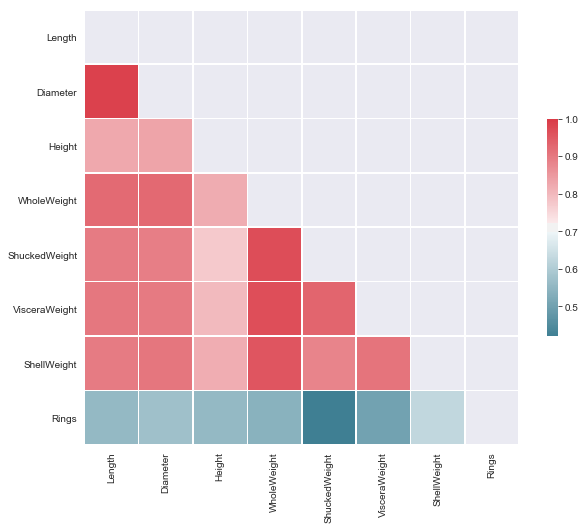

In [6]:
#Set plot style
sns.set_style('darkgrid')

#Compute the correlation matrix
corr = df.corr()

#Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, square=True,
           linewidth=0.5, cbar_kws={'shrink': 0.5}, ax=ax)

# Data Preprocessing and Feature Engineering

Create a new volume attribute out of lenght, diameter, and height:

In [7]:
#Create a volume attribute
df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
df.head()

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings,Volume
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.015777
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.008347
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.030051
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.020075
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0.006732


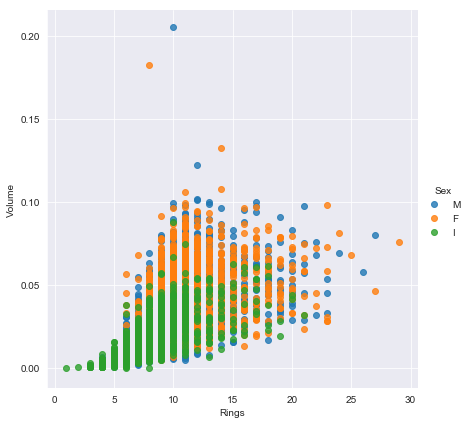

In [8]:
#Scatter plot
sns.lmplot(x='Rings', y='Volume', hue='Sex', data=df, fit_reg=False, height=6)

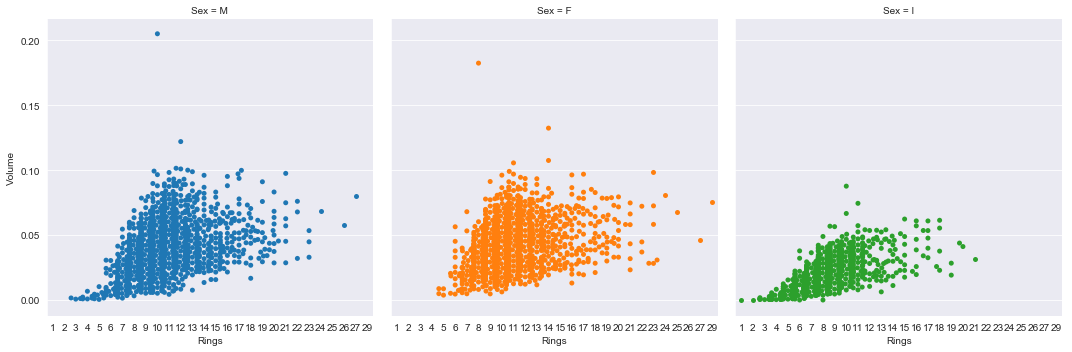

In [9]:
#Factor plot
sns.catplot(x='Rings', y='Volume', data=df, hue='Sex',
            col='Sex', kind='swarm', edgecolor='white')

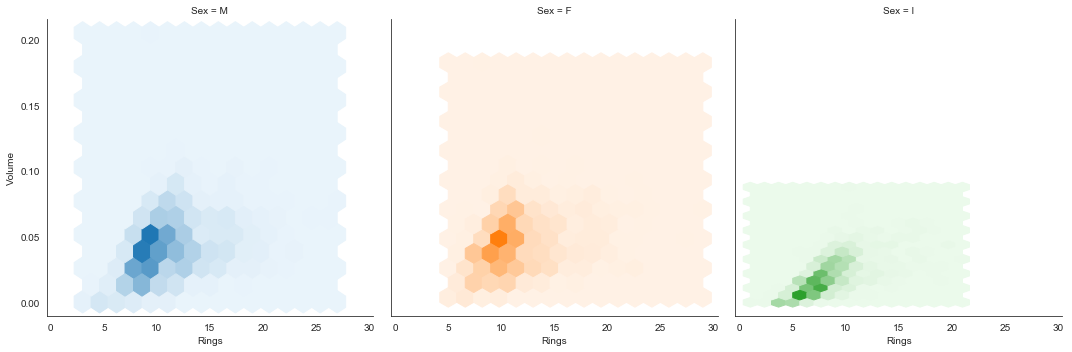

In [10]:
#hexbins plot, for fun :P
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style('white'):
    g = sns.FacetGrid(df, hue="Sex", col="Sex", height=5)
g.map(hexbin, 'Rings', 'Volume')

Need to encode the `Sex` column and create dummy variables:

In [11]:
#Converting the sex column into a dummy variables
one_hot = pd.get_dummies(df['Sex'])

#Drop the sex column as it is now encoded
df.drop('Sex', axis=1, inplace=True)

#Join the encoded vars
df = df.join(one_hot)

df.head()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings,Volume,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.015777,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.008347,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.030051,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.020075,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0.006732,0,1,0


Create an age column that is categorical based on arbitrarily chosen ranges of rings:

In [15]:
#Create the age column as a categorical attribute
df['Age'] = pd.cut(df['Rings'], bins=[0, 10, 20, float('Inf')],
                  labels=['young', 'adult', 'old'])

#Drop the rings column
df.drop('Rings', axis=1, inplace=True)

In [19]:
df.head()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Volume,F,I,M,Age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.015777,0,0,1,adult
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.008347,0,0,1,young
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.030051,1,0,0,young
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.020075,0,0,1,young
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.006732,0,1,0,young


In [20]:
#Get the final number of columns
df.shape

(4177, 12)

In [28]:
#Get the X set of predictors
X = df.iloc[:, 0:10].values
X

array([[0.455     , 0.365     , 0.095     , ..., 0.01577712, 0.        ,
        0.        ],
       [0.35      , 0.265     , 0.09      , ..., 0.0083475 , 0.        ,
        0.        ],
       [0.53      , 0.42      , 0.135     , ..., 0.030051  , 1.        ,
        0.        ],
       ...,
       [0.6       , 0.475     , 0.205     , ..., 0.058425  , 0.        ,
        0.        ],
       [0.625     , 0.485     , 0.15      , ..., 0.04546875, 1.        ,
        0.        ],
       [0.71      , 0.555     , 0.195     , ..., 0.07683975, 0.        ,
        0.        ]])

In [30]:
#Get the y set of target values
y = df.iloc[:, 11].values
y

[adult, young, young, young, young, ..., adult, young, young, young, adult]
Length: 4177
Categories (3, object): [young < adult < old]

In [85]:
#Encode the target variable
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([0, 2, 2, ..., 2, 2, 0], dtype=int64)

# Predictive modelling with Sklearn's KNN

In [32]:
#Import the library
from sklearn.model_selection import train_test_split

In [33]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [36]:
#Initial modelling with arbitrary K value
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#Initiate learning model
knn = KNeighborsClassifier(n_neighbors = 9)

#Fitting the model
knn.fit(X_train, y_train)

#Predict the response
pred = knn.predict(X_test)

#Evaluate accuracy
print(accuracy_score(y_test, pred))

0.7799043062200957


Carry out cross validation to find the optimal K:

In [44]:
#10-fold cross validation
my_K = list(range(1, 60))

#Subsetting just the odd numbers
neighbors = list(filter(lambda x: x % 2 != 0, my_K))

#List that will hold CV scores
cv_scores = []

#Perform 10-fold cross validation
from sklearn.model_selection import cross_val_score
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

Plot the misclassification error versus K:

The optimal number of neighbors is 13


Text(0,0.5,'Misclassification Error')

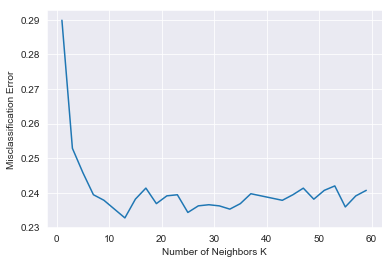

In [45]:
#changing to misclassification error
mse = [1 - x for x in cv_scores]

#determing bets K
optimal_k = neighbors[mse.index(min(mse))]
print('The optimal number of neighbors is %d' % optimal_k)

#Plot the MSE vs. K
plt.plot(neighbors, mse)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

In [48]:
#Running the model again with optimal K
knn = KNeighborsClassifier(n_neighbors = 13)

#Fitting the model
knn.fit(X_train, y_train)

#Predict the response
pred = knn.predict(X_test)

#Evaluate accuracy
print(accuracy_score(y_test, pred))

0.7875598086124402


# Writing my own KNN algorithm

A machine learning algorithm usually consists of 2 main blocks:
<ul>
    <li>a training block that takes as input the training data X and the corresponding target y and outputs a learned model h.</li>
    <li>a predict block that takes as input new and unseen observations and uses the function h to output their corresponding responses.</li>
</ul>

I write a lazy algorithm which just memorizes the training data:

In [80]:
from collections import Counter

def train(X_train, y_train):
    #do nothing
    return

def predict(X_train, y_train, X_test, k):
    #create list of distances and targets
    distances = []
    targets = []
    
    for i in range(len(X_train)):
        #first compute the euclidean distance
        distance = np.sqrt(np.sum(np.square(X_test - X_train[i, :])))
        #add it to the list of distances
        distances.append([distance, i])
        
    #sort the list
    distances = sorted(distances)
    
    #make a list of the k neighbors' targets
    for i in range(k):
        index = distances[i][1]
        targets.append(y_train[index])
        
    #return the most common target
    return Counter(targets).most_common(1)

In [81]:
def kNearestNeighbor(X_train, y_train, X_test, predictions, k):
    #train the input data
    train(X_train, y_train)
    
    #loop over all observations
    for i in range(len(X_test)):
        predictions.append(predict(X_train, y_train, X_test[i, :], k))

In [84]:
#Run with my algorithm
predictions = []

kNearestNeighbor(X_train, y_train, X_test, predictions, 13)

#transform the list into an array
predictions = np.array(predictions)

#evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print('The accuracy of the classifier is %d%%' % accuracy)

The accuracy of the classifier is 0%
